In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:

"""
train_type_condition_9.py
"""

import os
import sys
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# ---------- GANTI JIKA PAKAI COLAB / JUPYTER ----------
DEFAULT_NOTEBOOK_CSV_PATH = '/content/drive/MyDrive/Kuning Telur - CV/dataset_index.csv'
# ----------------------------------------------------

def _argv_has_csv(argv):
    for a in argv:
        if a == '--csv' or a.startswith('--csv='):
            return True
    return False

def get_args():
    parser = argparse.ArgumentParser(description="Train yolk TYPE+KONDISI(3 kondisi) classification (MobileNetV2)")
    parser.add_argument('--csv', type=str, required=True, help="Path to dataset_index.csv")
    parser.add_argument('--model_dir', type=str, default="/content/drive/MyDrive/Kuning Telur - CV/Model/ModelCNN_9")
    parser.add_argument('--img_size', type=int, default=224)
    parser.add_argument('--batch_size', type=int, default=32)
    parser.add_argument('--epochs', type=int, default=30)
    parser.add_argument('--random_state', type=int, default=42)
    parser.add_argument('--no_prefetch', action='store_true')
    parser.add_argument('--finetune_after', type=int, default=0)

    in_notebook = 'ipykernel' in sys.modules or 'google.colab' in sys.modules
    if in_notebook:
        if _argv_has_csv(sys.argv):
            args, _ = parser.parse_known_args()
        else:
            notebook_argv = [
                '--csv', DEFAULT_NOTEBOOK_CSV_PATH,
                '--epochs', '30'
            ]
            args, _ = parser.parse_known_args(notebook_argv)
    else:
        args = parser.parse_args()
    return args

args = get_args()

CSV_PATH = args.csv
MODEL_DIR = args.model_dir
IMG_SIZE = (args.img_size, args.img_size)
BATCH_SIZE = args.batch_size
EPOCHS = args.epochs
RANDOM_STATE = args.random_state
AUTOTUNE = tf.data.AUTOTUNE if not args.no_prefetch else None
FINETUNE_AFTER = args.finetune_after

os.makedirs(MODEL_DIR, exist_ok=True)

# ----------------- mapping jam -> kondisi (sesuaikan) -----------------
time_to_condition = {
    "12:30": "Segar",
    "13:00": "Segar",
    "13:30": "Kurang_Segar",
    "14:00": "Kurang_Segar",
    "14:30": "Tidak_Segar",
    "15:00": "Tidak_Segar",
}

# -------------------- Load dataset ----------------------
df = pd.read_csv(CSV_PATH)
required_cols = ['filepath', 'Label_Telur', 'Jam']
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"CSV harus ada kolom '{c}'")

# Filter hanya type yang valid
df = df[df['Label_Telur'].isin(["ayampetelur", "bebek", "puyuh"])].copy()

# Mapping kondisi dari jam
df['Kondisi'] = df['Jam'].map(time_to_condition)
df = df.dropna(subset=['Kondisi'])  # buang data jam yang tidak dikenali

# Gabungkan type + kondisi
df['Label_Final'] = df['Label_Telur'] + "_" + df['Kondisi']

# Buat mapping ke angka
LABEL_MAP = {name: idx for idx, name in enumerate(sorted(df['Label_Final'].unique()))}
df['label'] = df['Label_Final'].map(LABEL_MAP).astype('int32')

print("Samples total:", len(df))
print(df['Label_Final'].value_counts())
print("Label map:", LABEL_MAP)

# -------------------- Stratified split -------------------
train_df, test_df = train_test_split(df, test_size=0.15,
                                     stratify=df['label'],
                                     random_state=RANDOM_STATE)
train_df, val_df = train_test_split(train_df, test_size=0.15,
                                    stratify=train_df['label'],
                                    random_state=RANDOM_STATE)

# -------------------- Dataset pipeline -------------------
def df_to_tf_dataset(df_local, shuffle=True):
    filepaths = df_local['filepath'].astype(str).values
    labels = df_local['label'].astype('int32').values
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    def _load(fp, lbl):
        img = tf.io.read_file(fp)
        img = tf.io.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.cast(img, tf.float32)  # rentang 0..255
        return img, lbl

    ds = ds.map(_load, num_parallel_calls=AUTOTUNE if AUTOTUNE else 1)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000, seed=RANDOM_STATE)
    ds = ds.batch(BATCH_SIZE)
    if AUTOTUNE:
        ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = df_to_tf_dataset(train_df, shuffle=True)
val_ds = df_to_tf_dataset(val_df, shuffle=False)
test_ds = df_to_tf_dataset(test_df, shuffle=False)

# -------------------- Model builder ----------------------
def get_augmentation():
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.04),
        layers.RandomZoom(0.05),
        layers.RandomTranslation(0.02, 0.02),
        layers.RandomContrast(0.08),
    ], name="augmentation")

def build_model(num_classes):
    base = tf.keras.applications.MobileNetV2(
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    base.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3), dtype=tf.float32)
    x = get_augmentation()(inputs)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model, base

model, backbone = build_model(num_classes=len(LABEL_MAP))

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

# -------------------- Class weights ----------------------
y_train = train_df['label'].values
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

# -------------------- Callbacks --------------------------
ckpt_path = os.path.join(MODEL_DIR, "best_type_condition_model.h5")
cbs = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_accuracy", save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)
]

# -------------------- Training ---------------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs,
    class_weight=class_weight_dict
)

# -------------------- Optional Fine-tune -----------------
if FINETUNE_AFTER and FINETUNE_AFTER < EPOCHS:
    backbone.trainable = True
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
    )
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=FINETUNE_AFTER,
        callbacks=cbs,
        class_weight=class_weight_dict
    )

# -------------------- Evaluate ---------------------------
eval_res = model.evaluate(test_ds)
print("Eval results (loss, accuracy):", eval_res)

# -------------------- Save final model -------------------
final_model_path = os.path.join(MODEL_DIR, "final_type_condition_model.h5")
print("Saving final model to:", final_model_path)
model.save(final_model_path)
print("Selesai. Model disimpan ke", final_model_path)


Samples total: 1080
Label_Final
ayampetelur_Segar           120
bebek_Segar                 120
puyuh_Segar                 120
ayampetelur_Kurang_Segar    120
bebek_Kurang_Segar          120
puyuh_Kurang_Segar          120
ayampetelur_Tidak_Segar     120
bebek_Tidak_Segar           120
puyuh_Tidak_Segar           120
Name: count, dtype: int64
Label map: {'ayampetelur_Kurang_Segar': 0, 'ayampetelur_Segar': 1, 'ayampetelur_Tidak_Segar': 2, 'bebek_Kurang_Segar': 3, 'bebek_Segar': 4, 'bebek_Tidak_Segar': 5, 'puyuh_Kurang_Segar': 6, 'puyuh_Segar': 7, 'puyuh_Tidak_Segar': 8}
Class weights: {0: 0.9961685823754789, 1: 0.9961685823754789, 2: 0.9961685823754789, 3: 1.0077519379844961, 4: 1.0077519379844961, 5: 0.9961685823754789, 6: 1.0077519379844961, 7: 0.9961685823754789, 8: 0.9961685823754789}
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1185 - loss: 2.9389

25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.1197 - loss: 2.9314 - val_accuracy: 0.0942 - val_loss: 2.2232 - learning_rate: 1.0000e-04
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2375 - loss: 2.3128

25/25 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.2378 - loss: 2.3098 - val_accuracy: 0.2754 - val_loss: 1.8818 - learning_rate: 1.0000e-04
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3347 - loss: 1.9603

25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3355 - loss: 1.9581 - val_accuracy: 0.3913 - val_loss: 1.6367 - learning_rate: 1.0000e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3707 - loss: 1.7635

25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.3719 - loss: 1.7604 - val_accuracy: 0.5145 - val_loss: 1.4466 - learning_rate: 1.0000e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4557 - loss: 1.4885

25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.4563 - loss: 1.4875 - val_accuracy: 0.5290 - val_loss: 1.3220 - learning_rate: 1.0000e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5341 - loss: 1.3134

25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.5328 - loss: 1.3151 - val_accuracy: 0.5362 - val_loss: 1.2080 - learning_rate: 1.0000e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.5204 - loss: 1.2343 - val_accuracy: 0.5290 - val_loss: 1.1324 - learning_rate: 1.0000e-04
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5728 - loss: 1.1504

25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5731 - loss: 1.1496 - val_accuracy: 0.5580 - val_loss: 1.0612 - learning_rate: 1.0000e-04
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6108 - loss: 1.1001

25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6102 - loss: 1.0997 - val_accuracy: 0.5652 - val_loss: 1.0108 - learning_rate: 1.0000e-04
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6332 - loss: 0.9778

25/25 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.6329 - loss: 0.9785 - val_accuracy: 0.5870 - val_loss: 0.9513 - learning_rate: 1.0000e-04
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6372 - loss: 0.9226

25/25 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.6379 - loss: 0.9223 - val_accuracy: 0.6232 - val_loss: 0.8999 - learning_rate: 1.0000e-04
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6818 - loss: 0.8477

25/25 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.6817 - loss: 0.8484 - val_accuracy: 0.6377 - val_loss: 0.8522 - learning_rate: 1.0000e-04
Epoch 13/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6885 - loss: 0.8101 - val_accuracy: 0.6377 - val_loss: 0.8214 - learning_rate: 1.0000e-04
Epoch 14/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6921 - loss: 0.8465

25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.6928 - loss: 0.8446 - val_accuracy: 0.6449 - val_loss: 0.8056 - learning_rate: 1.0000e-04
Epoch 15/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6946 - loss: 0.8105

25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.6960 - loss: 0.8084 - val_accuracy: 0.6594 - val_loss: 0.8025 - learning_rate: 1.0000e-04
Epoch 16/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7717 - loss: 0.7102

25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.7716 - loss: 0.7097 - val_accuracy: 0.6812 - val_loss: 0.7923 - learning_rate: 1.0000e-04
Epoch 17/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7403 - loss: 0.6918

25/25 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7404 - loss: 0.6919 - val_accuracy: 0.7029 - val_loss: 0.7559 - learning_rate: 1.0000e-04
Epoch 18/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.7482 - loss: 0.7006 - val_accuracy: 0.7029 - val_loss: 0.7354 - learning_rate: 1.0000e-04
Epoch 19/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7779 - loss: 0.6268

25/25 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.7782 - loss: 0.6265 - val_accuracy: 0.7101 - val_loss: 0.7366 - learning_rate: 1.0000e-04
Epoch 20/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7847 - loss: 0.6048

25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.7846 - loss: 0.6044 - val_accuracy: 0.7754 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 21/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8086 - loss: 0.5968

25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8083 - loss: 0.5970 - val_accuracy: 0.7971 - val_loss: 0.6347 - learning_rate: 1.0000e-04
Epoch 22/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8010 - loss: 0.5781

25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.8011 - loss: 0.5782 - val_accuracy: 0.8116 - val_loss: 0.6097 - learning_rate: 1.0000e-04
Epoch 23/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7932 - loss: 0.5542

25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7932 - loss: 0.5548 - val_accuracy: 0.8478 - val_loss: 0.5749 - learning_rate: 1.0000e-04
Epoch 24/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8059 - loss: 0.5428

25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8062 - loss: 0.5421 - val_accuracy: 0.8551 - val_loss: 0.5563 - learning_rate: 1.0000e-04
Epoch 25/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8125 - loss: 0.5101

25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8125 - loss: 0.5108 - val_accuracy: 0.8696 - val_loss: 0.5405 - learning_rate: 1.0000e-04
Epoch 26/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8249 - loss: 0.4953

25/25 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8245 - loss: 0.4957 - val_accuracy: 0.8913 - val_loss: 0.5168 - learning_rate: 1.0000e-04
Epoch 27/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8416 - loss: 0.4761

25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8413 - loss: 0.4767 - val_accuracy: 0.8986 - val_loss: 0.5071 - learning_rate: 1.0000e-04
Epoch 28/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8348 - loss: 0.4796 - val_accuracy: 0.8986 - val_loss: 0.4998 - learning_rate: 1.0000e-04
Epoch 29/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.8473 - loss: 0.4693 - val_accuracy: 0.8986 - val_loss: 0.4800 - learning_rate: 1.0000e-04
Epoch 30/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8233 - loss: 0.4636 - val_accuracy: 0.8841 - val_loss: 0.4843 - learning_rate: 1.0000e-04
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.8796 - loss: 0.4901


Eval results (loss, accuracy): [0.4910352826118469, 0.8888888955116272]
Saving final model to: /content/drive/MyDrive/Kuning Telur - CV/Model/ModelCNN_9/final_type_condition_model.h5
Selesai. Model disimpan ke /content/drive/MyDrive/Kuning Telur - CV/Model/ModelCNN_9/final_type_condition_model.h5


/tmp/ipython-input-2325702032.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2325702032.py:28: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


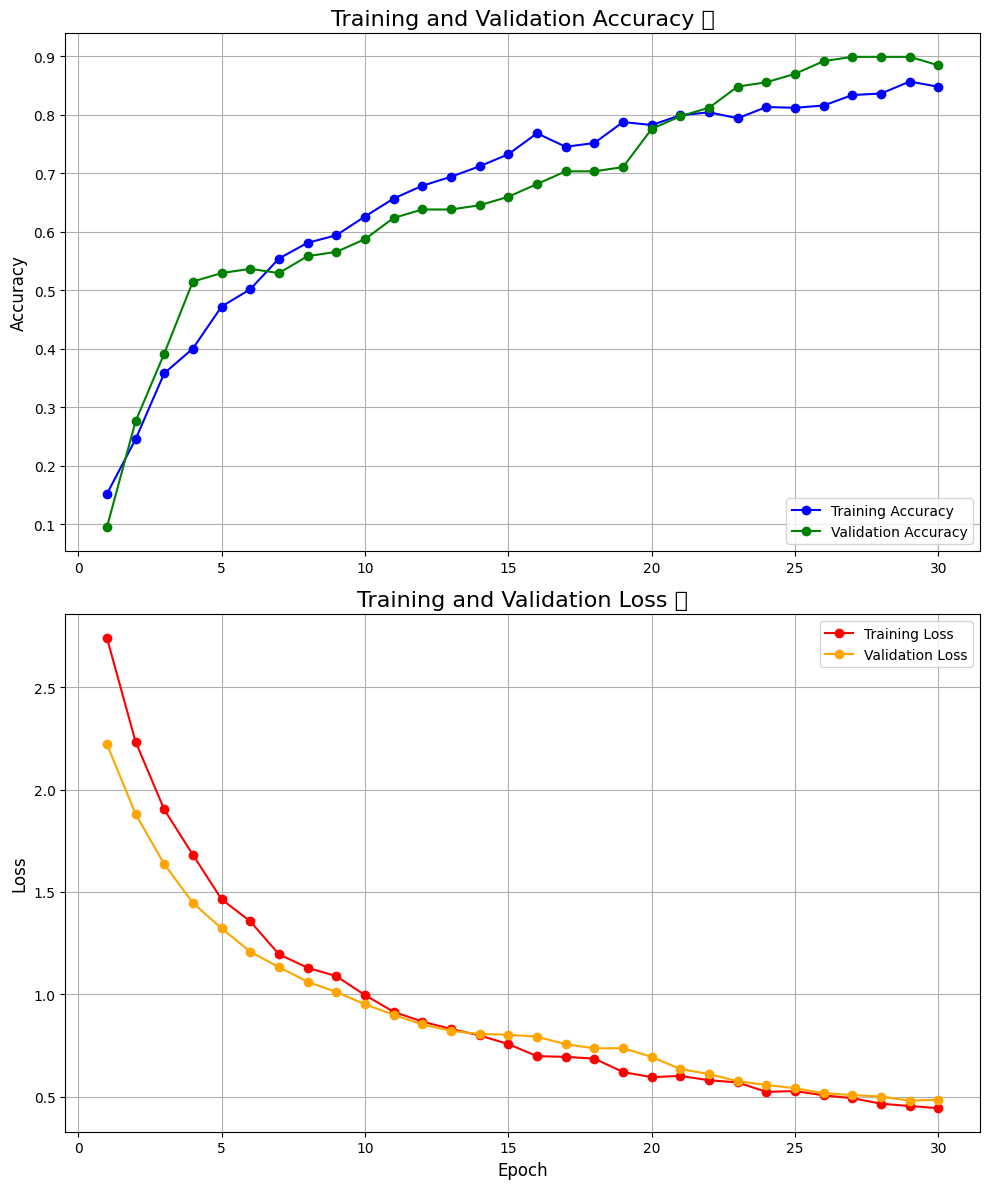

In [24]:
import matplotlib.pyplot as plt

# Ambil history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc)+1)

# Buat 2 subplot vertikal
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))  # lebar 10, tinggi 12

ax1.plot(epochs_range, acc, 'o-', label='Training Accuracy', color='b')
ax1.plot(epochs_range, val_acc, 'o-', label='Validation Accuracy', color='g')
ax1.set_title('Training and Validation Accuracy 📈', fontsize=16)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(loc='lower right')
ax1.grid(True)

ax2.plot(epochs_range, loss, 'o-', label='Training Loss', color='r')
ax2.plot(epochs_range, val_loss, 'o-', label='Validation Loss', color='orange')
ax2.set_title('Training and Validation Loss 📉', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

Confusion Matrix:
 [[18  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0]
 [ 1  1 16  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0]
 [ 0  0  0 12  6  0  0  0  0]
 [ 0  0  0  1  0 17  0  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  0 18  0]
 [ 0  0  0  0  0  0  0  3 15]]


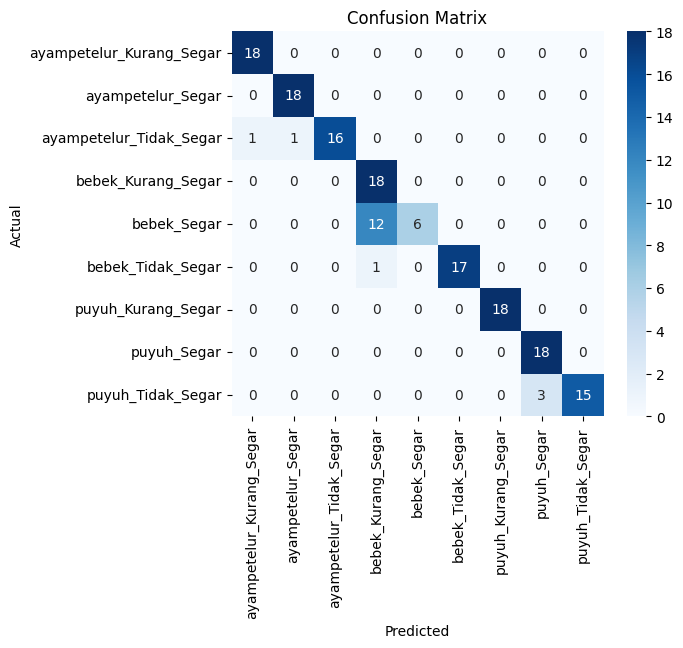


Classification Report:
                          precision    recall  f1-score   support

ayampetelur_Kurang_Segar       0.95      1.00      0.97        18
       ayampetelur_Segar       0.95      1.00      0.97        18
 ayampetelur_Tidak_Segar       1.00      0.89      0.94        18
      bebek_Kurang_Segar       0.58      1.00      0.73        18
             bebek_Segar       1.00      0.33      0.50        18
       bebek_Tidak_Segar       1.00      0.94      0.97        18
      puyuh_Kurang_Segar       1.00      1.00      1.00        18
             puyuh_Segar       0.86      1.00      0.92        18
       puyuh_Tidak_Segar       1.00      0.83      0.91        18

                accuracy                           0.89       162
               macro avg       0.93      0.89      0.88       162
            weighted avg       0.93      0.89      0.88       162



In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Ambil semua data test
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Plot pakai seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(LABEL_MAP.keys()),
            yticklabels=list(LABEL_MAP.keys()))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(LABEL_MAP.keys())))